#Import Libraries

In [ ]:
!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
!pip install keras-tuner
import keras_tuner as kt
print("Keras Tuner is installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00
Keras Tuner is installed successfully!


In [ ]:
# Mengimpor kembali pustaka yang diperlukan setelah reset
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Import Data

In [ ]:
csv_url = 'https://docs.google.com/spreadsheets/d/1at1-KUFm4nnRxRl5TcPd9Yl3yD6hNiRL/gviz/tq?tqx=out:csv&sheet=data'

# Membaca data dari CSV
df = pd.read_csv(csv_url)

# Konversi ke datetime
df.set_index('date', inplace=True)

df.head(10)

,temp,tempmax,tempmin,dew,humidity,winddir
date,,,,,,
1/1/2020,25.2,31.1,23.3,23.8,91.9,64.5
1/2/2020,25.8,30.1,22.7,23.4,87.1,258.7
1/3/2020,25.9,30.1,23.4,23.7,88.3,311.5
1/4/2020,25.7,30.1,23.6,23.7,89.1,251.0
1/5/2020,25.4,29.1,23.2,23.8,91.3,254.1
1/6/2020,25.7,31.1,22.9,23.8,89.8,340.6
1/7/2020,25.3,30.1,22.8,23.9,92.4,305.7
1/8/2020,25.4,29.1,23.1,24.1,92.6,226.6
1/9/2020,25.3,29.1,22.8,23.8,91.9,238.6


In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Normalisasi data menggunakan MinMaxScaler
feature_columns = ['tempmax', 'tempmin', 'dew', 'humidity', 'winddir']

f_transformer = MinMaxScaler().fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())

temp_transformer = MinMaxScaler().fit(train[['temp']])
train['temp'] = temp_transformer.transform(train[['temp']])
test['temp'] = temp_transformer.transform(test[['temp']])

# Fungsi untuk membuat dataset dengan time steps
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

<ipython-input-5-f4e2300ee8ad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
<ipython-input-5-f4e2300ee8ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
<ipython-input-5-f4e2300ee8ad>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

## Dropout

In [ ]:
# Definisi parameter eksperimen
optimizers = {
    "adam": tf.keras.optimizers.Adam(learning_rate=0.001),
    "adagrad": tf.keras.optimizers.Adagrad(learning_rate=0.001),
    "rmsprop": tf.keras.optimizers.RMSprop(learning_rate=0.001)
}

activations = ["relu", "tanh", "sigmoid"]
time_steps_list = [5, 10, 15]
dropout_rates = [0.01, 0.05, 0.1, 0.15, 0.2]  # Menghapus 0 dari dropout rates

# Menyimpan hasil evaluasi model
results = []

In [ ]:
import warnings
warnings.simplefilter("ignore")


for optimizer_name, activation, time_steps, dropout_rate in itertools.product(optimizers.keys(), activations, time_steps_list, dropout_rates):
    try:
        # Format nama variabel model
        model_name = f"gru_{optimizer_name}_{activation}_ts{time_steps}_d{int(dropout_rate * 100)}"

        # Debugging: Menampilkan eksperimen yang sedang berjalan
        print(f"Running: {model_name}")

        # Membuat dataset dengan time_steps yang berbeda
        X_train, y_train = createDataset(train, train['temp'], time_steps)
        X_test, y_test = createDataset(test, test['temp'], time_steps)

        # Pastikan y_train dan y_test dalam bentuk 2D array
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        # Buat instance optimizer baru setiap iterasi
        if optimizer_name == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        elif optimizer_name == "adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
        elif optimizer_name == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

        # Membangun model GRU
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
            tf.keras.layers.GRU(128, activation=activation, return_sequences=True),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.GRU(64, activation=activation, return_sequences=False),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1, activation='linear')
        ])

        # Compile model dengan optimizer yang dipilih
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

        # Melatih model
        history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluasi model
        y_pred = model.predict(X_test)

        # Pastikan y_pred dalam bentuk array NumPy
        if isinstance(y_pred, tf.Tensor):
            y_pred = y_pred.numpy()

        # Mengembalikan skala data
        y_test_actual = temp_transformer.inverse_transform(y_test).flatten()
        y_pred_actual = temp_transformer.inverse_transform(y_pred).flatten()

        # Menghitung metrik evaluasi
        mse = mean_squared_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

        # Simpan hasil evaluasi
        results.append([model_name, optimizer_name, activation, time_steps, dropout_rate, mse, rmse, mae, mape])

        # Debugging: Menampilkan hasil yang berhasil disimpan
        print(f"Completed: {model_name} | MSE: {mse}")

    except Exception as e:
        print(f"Error in {model_name}: {e}")

Running: gru_adam_relu_ts5_d1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Completed: gru_adam_relu_ts5_d1 | MSE: 1.373982699594491
Running: gru_adam_relu_ts5_d5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Completed: gru_adam_relu_ts5_d5 | MSE: 0.7077579460124523
Running: gru_adam_relu_ts5_d10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Completed: gru_adam_relu_ts5_d10 | MSE: 1.0876573742219464
Running: gru_adam_relu_ts5_d15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Completed: gru_adam_relu_ts5_d15 | MSE: 0.7858531462337484
Running: gru_adam_relu_ts5_d20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Completed: gru_adam_relu_ts5_d20 | MSE: 0.571849303075065
Running: gru_adam_relu_ts10_d1
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Completed: gru_adam_relu_ts10_d1 | MSE: 0.44511664253093003
Running: gru_adam_relu_ts10_d5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Completed: gru_adam_relu_ts10_d5 | MSE: 0.4534690457129099
Running: gru_adam_relu_ts10_d10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Completed: gru_adam_rel

In [ ]:
results.append([model_name, optimizer_name, activation, time_steps, dropout_rate, mse, rmse, mae, mape])

In [ ]:
# Simpan hasil ke dalam DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Optimizer", "Activation", "Time Steps", "Dropout Rate", "MSE", "RMSE", "MAE", "MAPE"])

print(df_results.head())  # Menampilkan 5 baris pertama hasil eksperimen

df_results.to_excel("eksperimen gru dropout 001-02.xlsx")

                   Model Optimizer Activation  Time Steps  Dropout Rate  \
0   gru_adam_relu_ts5_d1      adam       relu           5          0.01   
1   gru_adam_relu_ts5_d5      adam       relu           5          0.05   
2  gru_adam_relu_ts5_d10      adam       relu           5          0.10   
3  gru_adam_relu_ts5_d15      adam       relu           5          0.15   
4  gru_adam_relu_ts5_d20      adam       relu           5          0.20   

        MSE      RMSE       MAE      MAPE  
0  1.373983  1.172170  0.804635  3.133331  
1  0.707758  0.841284  0.588275  2.286951  
2  1.087657  1.042908  0.722947  2.798007  
3  0.785853  0.886484  0.642430  2.487746  
4  0.571849  0.756207  0.543270  2.121535  


### gru_adam_tanh_ts15_d1

In [ ]:
# URL CSV untuk sheet "mentah"
csv_url = 'https://docs.google.com/spreadsheets/d/1at1-KUFm4nnRxRl5TcPd9Yl3yD6hNiRL/gviz/tq?tqx=out:csv&sheet=data'
# Membaca data dari CSV
df = pd.read_csv(csv_url)
# Convert to Datetime
df.set_index('date', inplace=True)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Rescalling Training Data
f_transformer = MinMaxScaler()
feature_columns = ['tempmax', 'tempmin', 'dew', 'humidity', 'winddir']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
temp_transformer = MinMaxScaler()
temp_transformer = temp_transformer.fit(train[['temp']])
train['temp'] = temp_transformer.transform(train[['temp']])
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test['temp'] = temp_transformer.transform(test[['temp']])

#Splitting Data
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)
time_steps = 15
X_train, y_train = createDataset(train, train['temp'], time_steps)
X_test, y_test = createDataset(test, test['temp'], time_steps)

#### Model Building

In [ ]:
import tensorflow as tf

# Membuat model Sequential
gru_adam_tanh_ts15_d1 = tf.keras.Sequential()

# Menambahkan lapisan GRU pertama dengan 128 unit, aktivasi Tanh, dan Dropout 0.01
gru_adam_tanh_ts15_d1.add(tf.keras.layers.GRU(128, activation='tanh', dropout=0.01,
                             input_shape=(X_test.shape[1], X_test.shape[2]), return_sequences=True))

# Menambahkan lapisan GRU kedua dengan 64 unit, aktivasi Tanh, dan Dropout 0.01
gru_adam_tanh_ts15_d1.add(tf.keras.layers.GRU(64, activation='tanh', dropout=0.01))

# Menambahkan lapisan Dense untuk output
gru_adam_tanh_ts15_d1.add(tf.keras.layers.Dense(1, activation='linear'))

# Kompilasi model dengan optimizer Adam dan learning rate 0.001
gru_adam_tanh_ts15_d1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Melatih model
history_adam_tanh_ts15_d1 = gru_adam_tanh_ts15_d1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluasi model
gru_adam_tanh_ts15_d1.evaluate(X_test, y_test)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.1191 - mse: 0.1191 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - l

[0.007133790757507086, 0.007133790757507086]

#### Model Loss

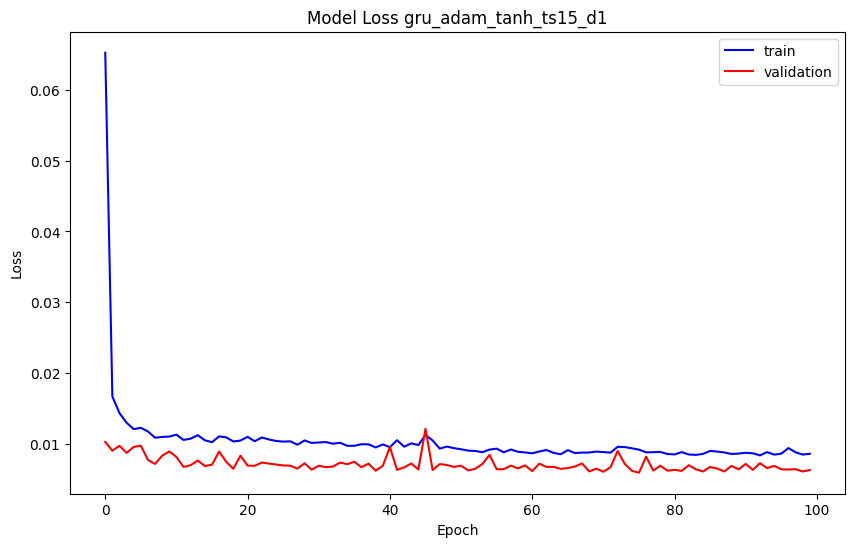

In [ ]:
# Grafik model loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_adam_tanh_ts15_d1.history['loss'], label='train', color='blue')
plt.plot(history_adam_tanh_ts15_d1.history['val_loss'], label='validation', color='red')
plt.title('Model Loss gru_adam_tanh_ts15_d1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### Evaluation

In [ ]:
# Prediksi pada data uji
y_pred_adam_tanh_ts15_d1 = gru_adam_tanh_ts15_d1.predict(X_test)
y_pred_adam_tanh_ts15_d1

# Mengembalikan skala data
y_test_actual = temp_transformer.inverse_transform([[0, 0, 0, 0, 0, 0, val] for val in y_test])[:, -1]
y_pred_actual_adam_tanh_ts15_d1 = temp_transformer.inverse_transform([[0, 0, 0, 0, 0, 0, val] for val in y_pred_adam_tanh_ts15_d1[:, 0]])[:, -1]

# Menghitung metrik evaluasi
mse_adam_tanh_ts15_d1 = mean_squared_error(y_test_actual, y_pred_actual_adam_tanh_ts15_d1)
rmse_adam_tanh_ts15_d1 = np.sqrt(mse_adam_tanh_ts15_d1)
mae_adam_tanh_ts15_d1 = mean_absolute_error(y_test_actual, y_pred_actual_adam_tanh_ts15_d1)
mape_adam_tanh_ts15_d1 = np.mean(np.abs((y_test_actual - y_pred_actual_adam_tanh_ts15_d1) / y_test_actual)) * 100

print(f"MSE gru_adam_tanh_ts15_d1: {mse_adam_tanh_ts15_d1}")
print(f"RMSE gru_adam_tanh_ts15_d1: {rmse_adam_tanh_ts15_d1}")
print(f"MAE gru_adam_tanh_ts15_d1: {mae_adam_tanh_ts15_d1}")
print(f"MAPE gru_adam_tanh_ts15_d1: {mape_adam_tanh_ts15_d1}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
MSE gru_adam_tanh_ts15_d1: 0.292200049166413
RMSE gru_adam_tanh_ts15_d1: 0.5405553155472741
MAE gru_adam_tanh_ts15_d1: 0.4106274972296065
MAPE gru_adam_tanh_ts15_d1: 1.609460411884691


#### Forecast Plot & Forecast Point

<Figure size 640x480 with 0 Axes>

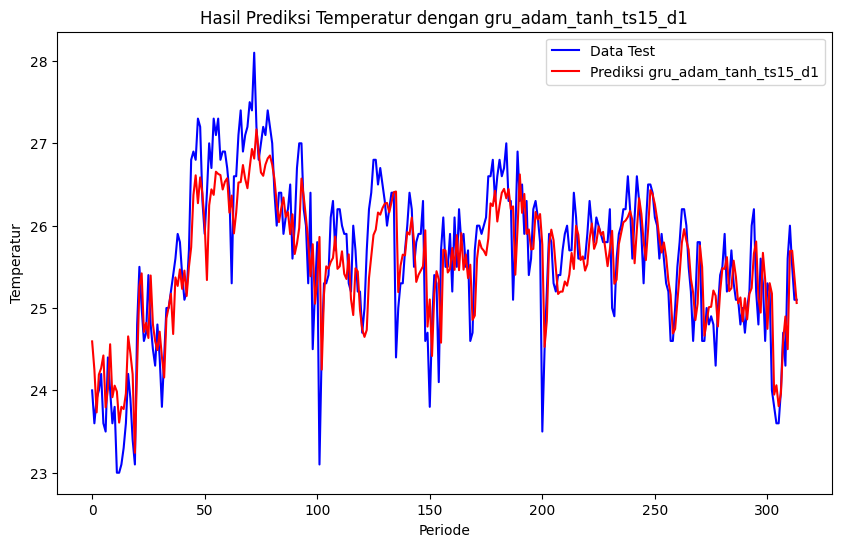

In [ ]:
# Visualisasi hasil prediksi
plt.figure(facecolor='white')  # Mengatur background figure menjadi putih
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Data Test', color='blue')
plt.plot(y_pred_actual_adam_tanh_ts15_d1, label='Prediksi gru_adam_tanh_ts15_d1', color='red')
plt.title('Hasil Prediksi Temperatur dengan gru_adam_tanh_ts15_d1')
plt.xlabel('Periode')
plt.ylabel('Temperatur')
plt.legend()
plt.show()

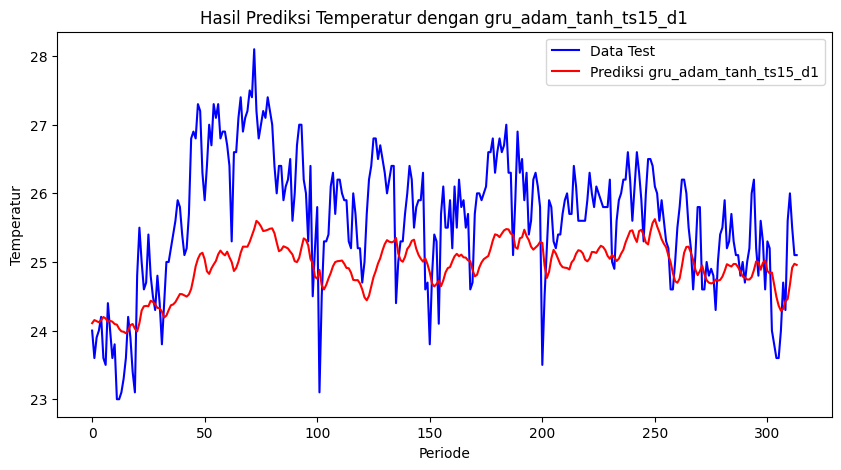

In [ ]:
import matplotlib.pyplot as plt

# Filter hasil untuk model gru_adam_tanh_ts15_d1
model_name_to_plot = "gru_adam_tanh_ts15_d1"

# Cari hasil prediksi yang sesuai
filtered_results = [res for res in results if res[0] == model_name_to_plot]

if filtered_results:
    _, _, _, _, _, mse, rmse, mae, mape = filtered_results[0]

    # Ambil hasil prediksi dari model yang sesuai
    y_test_actual = temp_transformer.inverse_transform(y_test).flatten()
    y_pred_actual = temp_transformer.inverse_transform(y_pred).flatten()

    # Plot hasil prediksi
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label="Data Test", color="blue")
    plt.plot(y_pred_actual, label=f"Prediksi {model_name_to_plot}", color="red")

    plt.title(f"Hasil Prediksi Temperatur dengan {model_name_to_plot}")
    plt.xlabel("Periode")
    plt.ylabel("Temperatur")
    plt.legend()
    plt.show()
else:
    print(f"Tidak ditemukan hasil untuk model {model_name_to_plot}.")

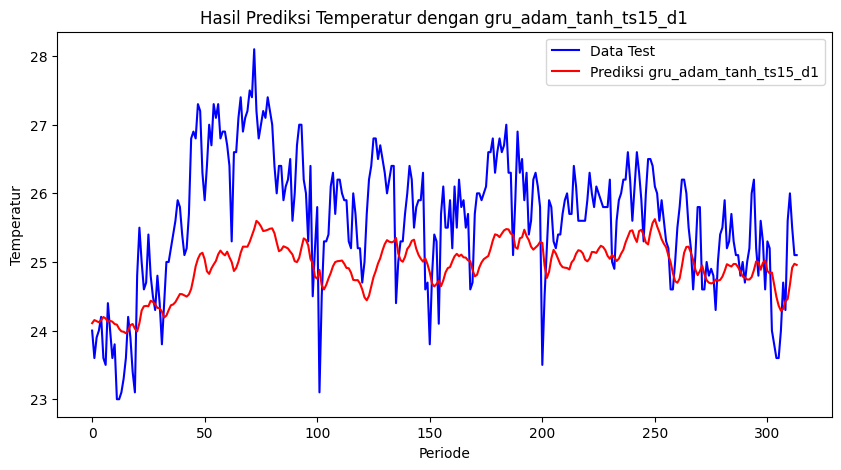

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi hasil untuk model tertentu
model_name_to_plot = "gru_adam_tanh_ts15_d1"  # Sesuai eksperimen tanpa dropout

# Cari hasil prediksi yang sesuai di results_no_dropout
filtered_results = [res for res in results if res[0] == model_name_to_plot]

if filtered_results:
    _, _, _, _, _, mse, rmse, mae, mape = filtered_results[0]

    # Ambil hasil prediksi dari model yang sesuai
    y_test_actual = temp_transformer.inverse_transform(y_test).flatten()
    y_pred_actual = temp_transformer.inverse_transform(y_pred).flatten()

    # Plot hasil prediksi
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label="Data Test", color="blue")
    plt.plot(y_pred_actual, label=f"Prediksi {model_name_to_plot}", color="red")

    plt.title(f"Hasil Prediksi Temperatur dengan {model_name_to_plot}")
    plt.xlabel("Periode")
    plt.ylabel("Temperatur")
    plt.legend()
    plt.show()
else:
    print(f"Tidak ditemukan hasil untuk model {model_name_to_plot}.")

## Without Dropout

In [ ]:
# Definisi parameter eksperimen tanpa dropout
optimizers_no_dropout = {
    "adam": tf.keras.optimizers.Adam(learning_rate=0.001),
    "adagrad": tf.keras.optimizers.Adagrad(learning_rate=0.001),
    "rmsprop": tf.keras.optimizers.RMSprop(learning_rate=0.001)
}

activations_no_dropout = ["relu", "tanh", "sigmoid"]
time_steps_list_no_dropout = [5, 10, 15]
dropout_rates_no_dropout = [0]  # Tanpa dropout

# Menyimpan hasil evaluasi model tanpa dropout
results_no_dropout = []

In [ ]:
import warnings
warnings.simplefilter("ignore")

# Looping untuk setiap kombinasi eksperimen tanpa dropout
for optimizer_name, activation, time_steps, dropout_rate in itertools.product(
    optimizers_no_dropout.keys(), activations_no_dropout, time_steps_list_no_dropout, dropout_rates_no_dropout
):
    try:
        # Bersihkan sesi sebelumnya agar model lama tidak menumpuk
        tf.keras.backend.clear_session()

        # Format nama model
        model_name_no_dropout = f"gru_{optimizer_name}_{activation}_ts{time_steps}_d0"

        print(f"Running: {model_name_no_dropout}")

        # Buat dataset dengan time_steps yang berbeda
        X_train, y_train = createDataset(train, train['temp'], time_steps)
        X_test, y_test = createDataset(test, test['temp'], time_steps)

        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        # Buat instance optimizer baru setiap iterasi
        if optimizer_name == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        elif optimizer_name == "adagrad":
            optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
        elif optimizer_name == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

        # Bangun model tanpa dropout
        model_no_dropout = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
            tf.keras.layers.GRU(128, activation=activation, return_sequences=True),
            tf.keras.layers.GRU(64, activation=activation, return_sequences=False),
            tf.keras.layers.Dense(1, activation='linear')
        ])

        # Compile model
        model_no_dropout.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

        # Latih model
        history_no_dropout = model_no_dropout.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluasi model
        y_pred_no_dropout = model_no_dropout.predict(X_test)

        # Konversi tensor ke numpy
        if isinstance(y_pred_no_dropout, tf.Tensor):
            y_pred_no_dropout = y_pred_no_dropout.numpy()

        # Mengembalikan skala data
        y_test_actual_no_dropout = temp_transformer.inverse_transform(y_test).flatten()
        y_pred_actual_no_dropout = temp_transformer.inverse_transform(y_pred_no_dropout).flatten()

        # Hitung metrik evaluasi
        mse_no_dropout = mean_squared_error(y_test_actual_no_dropout, y_pred_actual_no_dropout)
        rmse_no_dropout = np.sqrt(mse_no_dropout)
        mae_no_dropout = mean_absolute_error(y_test_actual_no_dropout, y_pred_actual_no_dropout)
        mape_no_dropout = np.mean(np.abs((y_test_actual_no_dropout - y_pred_actual_no_dropout) / y_test_actual_no_dropout)) * 100

        # Simpan hasil evaluasi
        results_no_dropout.append([
            model_name_no_dropout, optimizer_name, activation, time_steps, dropout_rate,
            mse_no_dropout, rmse_no_dropout, mae_no_dropout, mape_no_dropout
        ])

        print(f"Completed: {model_name_no_dropout} | MSE: {mse_no_dropout}")

    except Exception as e:
        print(f"Error in {model_name_no_dropout}: {e}")

Running: gru_adam_relu_ts5_d0
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Completed: gru_adam_relu_ts5_d0 | MSE: 2.919133655756053
Running: gru_adam_relu_ts10_d0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Completed: gru_adam_relu_ts10_d0 | MSE: 0.6206392229615411
Running: gru_adam_relu_ts15_d0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Completed: gru_adam_relu_ts15_d0 | MSE: 0.31467368425119796
Running: gru_adam_tanh_ts5_d0
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Completed: gru_adam_tanh_ts5_d0 | MSE: 0.3949697313505367
Running: gru_adam_tanh_ts10_d0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Completed: gru_adam_tanh_ts10_d0 | MSE: 0.3275378214058521
Running: gru_adam_tanh_ts15_d0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Completed: gru_adam_tanh_ts15_d0 | MSE: 0.3711414487007696
Running: gru_adam_sigmoid_ts5_d0
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Completed: gru_adam_sigmoid_ts5_d0 | MSE: 0.31803294754640254
Running: gru_adam_sigmoid_ts10_d0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Completed: gru_

In [ ]:
results_no_dropout.append([model_name, optimizer_name, activation, time_steps, dropout_rate, mse, rmse, mae, mape])

In [ ]:
# Simpan hasil ke dalam DataFrame
# Simpan hasil ke dalam DataFrame
df_results_no_dropout = pd.DataFrame(results_no_dropout, columns=[
    "Model", "Optimizer", "Activation", "Time Steps", "Dropout Rate", "MSE", "RMSE", "MAE", "MAPE"
])

print(df_results_no_dropout.head())  # Menampilkan 5 baris pertama hasil eksperimen

df_results_no_dropout.to_excel("eksperimen gru dropout 0.xlsx")

                   Model Optimizer Activation  Time Steps  Dropout Rate  \
0   gru_adam_relu_ts5_d0      adam       relu           5             0   
1  gru_adam_relu_ts10_d0      adam       relu          10             0   
2  gru_adam_relu_ts15_d0      adam       relu          15             0   
3   gru_adam_tanh_ts5_d0      adam       tanh           5             0   
4  gru_adam_tanh_ts10_d0      adam       tanh          10             0   

        MSE      RMSE       MAE      MAPE  
0  2.919134  1.708547  1.095066  4.291319  
1  0.620639  0.787807  0.583677  2.268442  
2  0.314674  0.560958  0.425460  1.660874  
3  0.394970  0.628466  0.491293  1.912315  
4  0.327538  0.572309  0.429132  1.682113  


### gru_adam_relu_ts15_d0

In [ ]:
# URL CSV untuk sheet "mentah"
csv_url = 'https://docs.google.com/spreadsheets/d/1at1-KUFm4nnRxRl5TcPd9Yl3yD6hNiRL/gviz/tq?tqx=out:csv&sheet=data'
# Membaca data dari CSV
df = pd.read_csv(csv_url)
# Convert to Datetime
df.set_index('date', inplace=True)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Rescalling Training Data
f_transformer = MinMaxScaler()
feature_columns = ['tempmax', 'tempmin', 'dew', 'humidity', 'winddir']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
temp_transformer = MinMaxScaler()
temp_transformer = temp_transformer.fit(train[['temp']])
train['temp'] = temp_transformer.transform(train[['temp']])
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test['temp'] = temp_transformer.transform(test[['temp']])

#Splitting Data
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)
time_steps = 15
X_train, y_train = createDataset(train, train['temp'], time_steps)
X_test, y_test = createDataset(test, test['temp'], time_steps)

#### Model Building

In [ ]:
import tensorflow as tf

# Membuat model Sequential
gru_adam_relu_ts15_d0 = tf.keras.Sequential()

# Menambahkan lapisan GRU pertama dengan 128 unit dan aktivasi ReLU tanpa dropout
gru_adam_relu_ts15_d0.add(tf.keras.layers.GRU(128, activation='relu',
                             input_shape=(X_test.shape[1], X_test.shape[2]),
                             return_sequences=True))

# Menambahkan lapisan GRU kedua dengan 64 unit dan aktivasi ReLU tanpa dropout
gru_adam_relu_ts15_d0.add(tf.keras.layers.GRU(64, activation='relu'))

# Menambahkan lapisan Dense untuk output
gru_adam_relu_ts15_d0.add(tf.keras.layers.Dense(1, activation='linear'))

# Kompilasi model dengan optimizer Adam dan learning rate 0.001
gru_adam_relu_ts15_d0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Melatih model
history_adam_relu_ts15_d0 = gru_adam_relu_ts15_d0.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

# Evaluasi model
gru_adam_relu_ts15_d0.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - mse: 0.0076


[0.007247444242238998, 0.007247444242238998]

#### Model Loss

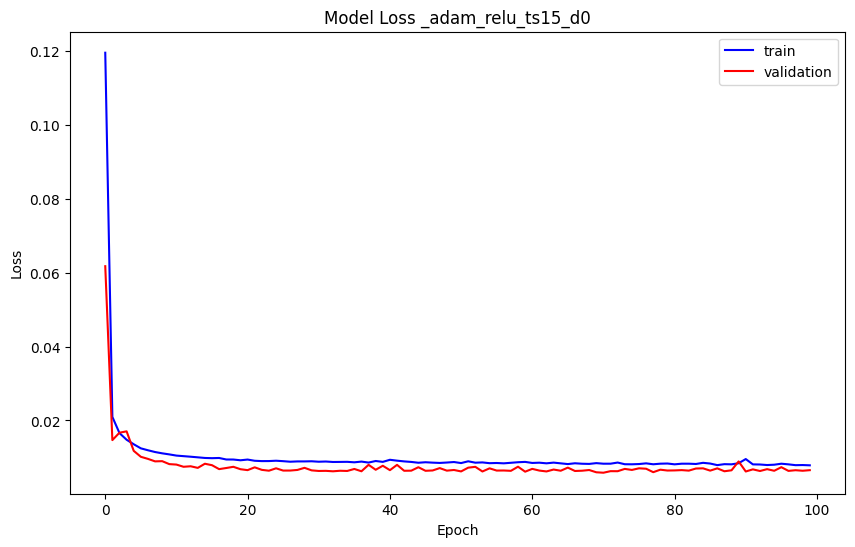

In [ ]:
# Grafik model loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_adam_relu_ts15_d0.history['loss'], label='train', color='blue')
plt.plot(history_adam_relu_ts15_d0.history['val_loss'], label='validation', color='red')
plt.title('Model Loss _adam_relu_ts15_d0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### Evaluation

In [ ]:
# Prediksi pada data uji
y_pred_adam_relu_ts15_d0 = gru_adam_relu_ts15_d0.predict(X_test)
y_pred_adam_relu_ts15_d0

# Mengembalikan skala data
y_test_actual = temp_transformer.inverse_transform([[0, 0, 0, 0, 0, 0, val] for val in y_test])[:, -1]
y_pred_actual_adam_relu_ts15_d0 = temp_transformer.inverse_transform([[0, 0, 0, 0, 0, 0, val] for val in y_pred_adam_relu_ts15_d0[:, 0]])[:, -1]

# Menghitung metrik evaluasi
mse_adam_relu_ts15_d0 = mean_squared_error(y_test_actual, y_pred_actual_adam_relu_ts15_d0)
rmse_adam_relu_ts15_d0 = np.sqrt(mse_adam_relu_ts15_d0)
mae_adam_relu_ts15_d0 = mean_absolute_error(y_test_actual, y_pred_actual_adam_relu_ts15_d0)
mape_adam_relu_ts15_d0 = np.mean(np.abs((y_test_actual - y_pred_actual_adam_relu_ts15_d0) / y_test_actual)) * 100

print(f"MSE gru_adam_relu_ts15_d0: {mse_adam_relu_ts15_d0}")
print(f"RMSE gru_adam_relu_ts15_d0: {rmse_adam_relu_ts15_d0}")
print(f"MAE gru_adam_relu_ts15_d0: {mae_adam_relu_ts15_d0}")
print(f"MAPE gru_adam_relu_ts15_d0: {mape_adam_relu_ts15_d0}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MSE gru_adam_relu_ts15_d0: 0.29685527159748765
RMSE gru_adam_relu_ts15_d0: 0.5448442636180431
MAE gru_adam_relu_ts15_d0: 0.40492140958263617
MAPE gru_adam_relu_ts15_d0: 1.58561981924825


#### Forecast Plot & Forecast Point

<Figure size 640x480 with 0 Axes>

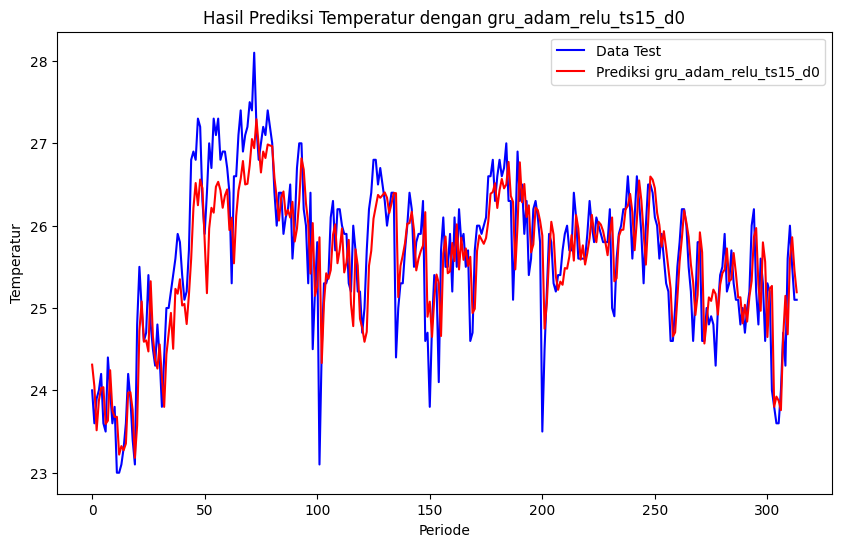

In [ ]:
# Visualisasi hasil prediksi
plt.figure(facecolor='white')  # Mengatur background figure menjadi putih
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Data Test', color='blue')
plt.plot(y_pred_actual_adam_relu_ts15_d0, label='Prediksi gru_adam_relu_ts15_d0', color='red')
plt.title('Hasil Prediksi Temperatur dengan gru_adam_relu_ts15_d0')
plt.xlabel('Periode')
plt.ylabel('Temperatur')
plt.legend()
plt.show()